# Man-Woman Detection with Transfer Learning

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

## 1- Dataset Preparation

### 1-1. Prepare kaggle requirements

In [2]:
# Upload your kaggle.json (which you got from your kaggle account: https://www.kaggle.com/settings/account)
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Move kaggle.json to the desired location
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### 1-2. Download dataset

In [4]:
!kaggle datasets download -d saadpd/menwomen-classification

 99% 796M/806M [00:08<00:00, 131MB/s]
100% 806M/806M [00:09<00:00, 92.8MB/s]


In [5]:
!unzip -qq menwomen-classification.zip

### 1-3. Evaluate the dataset

In [6]:
import os

num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: men: {num_men_train} | women: {num_women_train}')
print(f'Test: men: {num_men_test} | women: {num_women_test}')

Train: men: 1000 | women: 1912
Test: men: 418 | women: 915


### 1-4. Prepare data directories

In [7]:
import shutil, pathlib

new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
            os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(base_dir, category, fname),
            dst=os.path.join(dir, fname))

In [8]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=999)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

### 1-5. Load Dataset

In [9]:
print('Train loader:')
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary',
)

print('Validation loader:')
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary',
)
print('Test loader:')
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary',
)

Train loader:
Found 1598 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


### 1-6. Evalualte the final dataset

data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


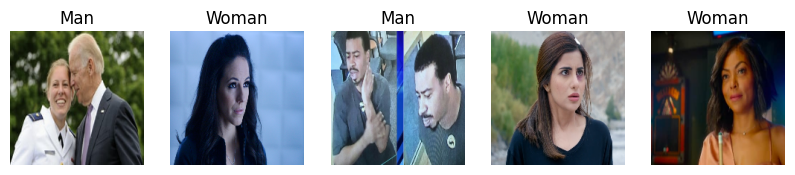

In [19]:
# Get one batch (containing 32 random images) from training dataset
# You will get different set of images on each run of this cell
for data_batch, label_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('label batch shape:', label_batch.shape)

    # Show five random examples of the loaded batch
    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    for i, ax in enumerate(axes):
        ax.imshow(data_batch[i].numpy().astype('uint8'))
        ax.set_axis_off()
        ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
    break

plt.show()

-----

## 2- Model Design

### 2-1. Augmentation model

In [10]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
    ])

### 2-2. Pre-trained Base model (VGG16)

In [11]:
conv_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
# Freeze the entire base model
conv_base.trainable = False

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### 2-3. Full model

In [14]:
inp = layers.Input(shape=(180, 180, 3))
x = data_augmentation(inp)
x = preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

-----

## 3- Training

### 3-1. Callbacks

In [15]:
checkpoint = callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True, monitor="val_loss")
logger = callbacks.CSVLogger('logg_step1.csv')
rlrop = callbacks.ReduceLROnPlateau(patience=5)

callbacks1 = [checkpoint, logger, rlrop]

### 3-2. Training hyper-parameters

In [16]:
model.compile(loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])

### 3-3. Step1: Classification head

In [17]:
history1 = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks1)

Epoch 1/25
50/50 [==============================] - 35s 403ms/step - loss: 1.2640 - accuracy: 0.6996 - val_loss: 0.6265 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 2/25
50/50 [==============================] - 16s 285ms/step - loss: 0.6208 - accuracy: 0.7991 - val_loss: 0.4293 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 3/25
50/50 [==============================] - 17s 292ms/step - loss: 0.4462 - accuracy: 0.8273 - val_loss: 0.3893 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 4/25
50/50 [==============================] - 16s 287ms/step - loss: 0.4419 - accuracy: 0.8110 - val_loss: 0.3354 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 5/25
50/50 [==============================] - 16s 284ms/step - loss: 0.3282 - accuracy: 0.8467 - val_loss: 0.3417 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 6/25
50/50 [==============================] - 16s 285ms/step - loss: 0.3122 - accuracy: 0.8761 - val_loss: 0.3473 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/25
50/50 [==============================] - 16s 284ms/st

#### History plots for Step1 

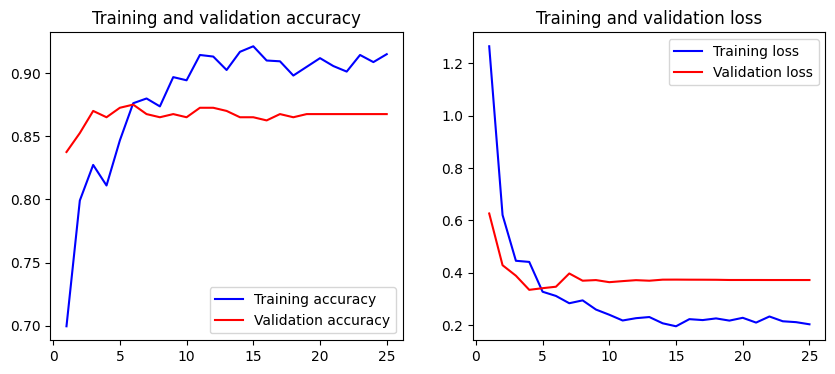

In [18]:
accuracy1 = history1.history["accuracy"]
val_accuracy1 = history1.history["val_accuracy"]
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
epochs = range(1, len(accuracy1) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].plot(epochs, accuracy1, "b", label="Training accuracy")
axes[0].plot(epochs, val_accuracy1, "r", label="Validation accuracy")
axes[0].set_title("Training and validation accuracy")
axes[0].legend()

axes[1].plot(epochs, loss1, "b", label="Training loss")
axes[1].plot(epochs, val_loss1, "r", label="Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].legend()

plt.show()

### 3-4. Step2: Fine-tuninng

In [19]:
# Freeze all layers, except the last conv block (last 4 layers)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [20]:
# Start with lower learning rate, because we are in the middle of process
model.compile(loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"])

In [21]:
checkpoint = callbacks.ModelCheckpoint(
    filepath="fine-tuning.keras",
    save_best_only=True, monitor="val_loss")
logger = callbacks.CSVLogger('logg_step2.csv')
rlrop = callbacks.ReduceLROnPlateau(patience=5)

callbacks2 = [checkpoint, logger, rlrop]

In [22]:
# Continue training from previous step
history2 = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks2)

Epoch 1/25
50/50 [==============================] - 21s 292ms/step - loss: 0.2077 - accuracy: 0.9111 - val_loss: 0.3860 - val_accuracy: 0.8725 - lr: 1.0000e-05
Epoch 2/25
50/50 [==============================] - 16s 291ms/step - loss: 0.1843 - accuracy: 0.9237 - val_loss: 0.4007 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 3/25
50/50 [==============================] - 17s 303ms/step - loss: 0.1603 - accuracy: 0.9380 - val_loss: 0.4065 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 4/25
50/50 [==============================] - 16s 285ms/step - loss: 0.1563 - accuracy: 0.9393 - val_loss: 0.3940 - val_accuracy: 0.8700 - lr: 1.0000e-05
Epoch 5/25
50/50 [==============================] - 17s 294ms/step - loss: 0.1416 - accuracy: 0.9412 - val_loss: 0.4042 - val_accuracy: 0.8800 - lr: 1.0000e-05
Epoch 6/25
50/50 [==============================] - 18s 325ms/step - loss: 0.1216 - accuracy: 0.9537 - val_loss: 0.4190 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 7/25
50/50 [======================

#### History plots for Step2

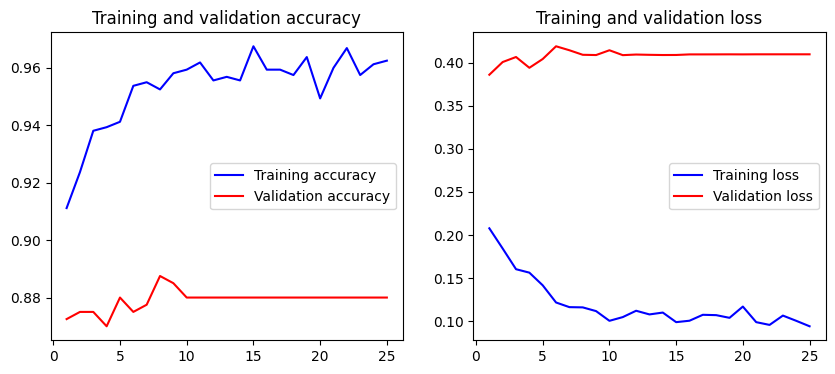

In [23]:
accuracy2 = history2.history["accuracy"]
val_accuracy2 = history2.history["val_accuracy"]
loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]
epochs = range(1, len(accuracy2) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].plot(epochs, accuracy2, "b", label="Training accuracy")
axes[0].plot(epochs, val_accuracy2, "r", label="Validation accuracy")
axes[0].set_title("Training and validation accuracy")
axes[0].legend()

axes[1].plot(epochs, loss2, "b", label="Training loss")
axes[1].plot(epochs, val_loss2, "r", label="Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].legend()

plt.show()

## 4- Evaluation

### 4-1. History plots of both steps

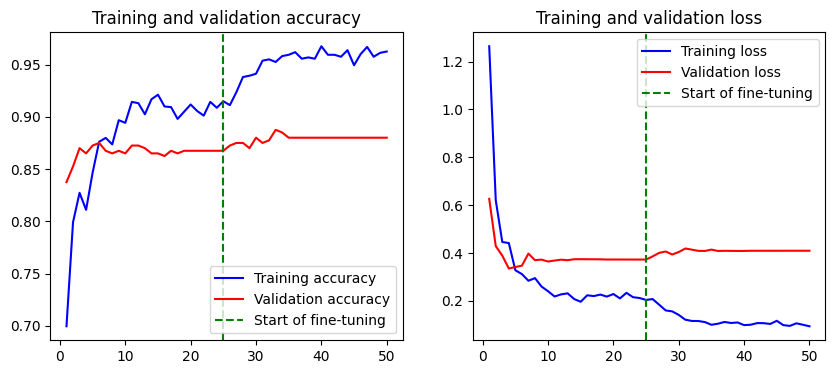

In [28]:
# Plot history of both steps
accuracy_all = accuracy1 + accuracy2
val_accuracy_all = val_accuracy1 + val_accuracy2
loss_all = loss1 + loss2
val_loss_all = val_loss1 + val_loss2
epochs = range(1, len(accuracy_all) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(epochs, accuracy_all, "b", label="Training accuracy")
axes[0].plot(epochs, val_accuracy_all, "r", label="Validation accuracy")
axes[0].set_title("Training and validation accuracy")
axes[0].axvline(x=25, color='g', linestyle='--', label='Start of fine-tuning')
axes[0].legend()

axes[1].plot(epochs, loss_all, "b", label="Training loss")
axes[1].plot(epochs, val_loss_all, "r", label="Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].axvline(x=25, color='g', linestyle='--', label='Start of fine-tuning')
axes[1].legend()

plt.show()


### 4-2. Evaluate on test dataset

In [25]:
model.evaluate(test_dataset)

25/25 [==============================] - 5s 163ms/step - loss: 0.2689 - accuracy: 0.9250


[0.2688535451889038, 0.925000011920929]

## 5- Backup model in Google Drive

In [30]:
model.save('Final_model_last_epoch.h5')

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
!cp 'fine-tuned.keras' '/content/drive/MyDrive/fine-tuned.keras'
!cp 'final_model_last_epoch.h5' '/content/drive/MyDrive/final_model_last_epoch.h5'